In [192]:
import numpy as np
import thermo_funcs_two as tf
import matplotlib.pyplot as plt

from scipy.optimize import minimize, fsolve, least_squares
from numpy.polynomial import Polynomial

In [193]:
def noise(transf,E_mids,occupf_L, occupf_R, coeff, type = "full"):
    plusF = occupf_L(E_mids)*(1-occupf_R(E_mids)) + occupf_R(E_mids)*(1-occupf_L(E_mids))
    occupdiff = occupf_L(E_mids) - occupf_R(E_mids)
    term_one = coeff(E_mids)**2 *(transf *plusF)
    term_two = - coeff(E_mids)**2 * transf**2*occupdiff**2
    if type == "full":
        integrands =  term_one + term_two
    elif type == "classic":
        integrands = term_one
    elif type == "quantum":
        integrands = term_two
    elif type == "thermal":
        integrands = coeff(E_mids)**2*transf*(occupf_L(E_mids)*(1-occupf_L(E_mids)) + occupf_R(E_mids)*(1-occupf_R(E_mids)))

    return np.sum(integrands)


def maybe_transf(E_mids, occupf_L, occupf_R, coeff, target):
    plusF = occupf_L(E_mids)*(1-occupf_R(E_mids)) + occupf_R(E_mids)*(1-occupf_L(E_mids))
    occupdiff = occupf_L(E_mids) - occupf_R(E_mids)
    unknown_transf = lambda lamda: plusF/(2*occupdiff**2) - lamda/(2*coeff(E_mids)*occupdiff)
    func = lambda lamda: tf.slice_current_integral(unknown_transf(lamda), E_mids,occupf_L, occupf_R, coeff) - target
    res = fsolve(func, 1)
    transf = unknown_transf(res[0])
    print(res[0])
    return transf



def noise_maximize_eff(transf, E_mids,occupf_L, occupf_R, coeff_in, coeff_out, type = "full"):
    input = noise(transf, E_mids,occupf_L, occupf_R, coeff_in, type)
    output = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff_out)
    eff = output/input
    return -eff

def minimize_noise_avg(transf, E_mids,occupf_L, occupf_R, coeff_in, coeff_out, type = "thermal"):
    nois = noise(transf, E_mids,occupf_L, occupf_R, coeff_out, type)
    avg = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff_in)
    #print(nois)
    #print(avg)

    #nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
    #input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
    #print(nois*avg)
    return nois*avg

def positive_current(transf, E_mids,occupf_L, occupf_R, coeff):
    avg = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff)
    return avg

def noise_constraint(transf, E_mids,occupf_L, occupf_R, coeff, target):
    current = tf.slice_current_integral(transf, E_mids,occupf_L, occupf_R, coeff)
    return target-current
def def_pert(E, muL, TL, muR, TR):
    E0 = tf.E_max(muL,TL,muR,TR)
    #pert = 0.5*fermi_dist(E, muL+0.1, TL + 0.1)  - 0.5*fermi_dist(E,muL,TL)
    #ratio = ((-1-E0)/(5-E0)).as_integer_ratio()
    pert = 0.1*np.sin((E - E0)*8*np.pi/(5-E0))*np.exp(-0.5*np.abs(E-E0))
    #print(type(E))
    if type(E) == np.ndarray:
        pert[E > 5] = 0
        pert[E < -1] = 0
    else:
        if E > 5:
            pert = 0
        if E < -1:
            pert = 0
    #pert = np.ones_like(E)*0.2
    #pert[E<0.2] = 0
    #pert[E>1] = 0 
    #pert[pert > 1] = 1
    #pert[pert < 0] = 0
    return pert

In [194]:
'''
T = 1
    deltaT = 0.5
    TL = T+deltaT
    TR = T-deltaT
    muR = 0
    init_muL = -1
    deltamu = init_muL-muR
    N = 1
    tf.N = N
    target_power = 0.6*tf.pmax(TL,TR)
    small_E_range = np.linspace(-1,5,100)
'''
Es = np.linspace(-1,5,100)
deltaT = 0.5
muL = -1
TR = 1-deltaT
TL = 1+deltaT
muR = 0

occupf_L = lambda E: tf.pertub_dist(E, lambda E: tf.fermi_dist(E, muL, TL), def_pert(E, muL, TL, muR, TR))
#occupf_L = lambda E: 0.2*np.sin(4*E)+0.5
#occupf_L = lambda E: tf.fermi_dist(E, muL, TL)
occupf_R = lambda E: tf.fermi_dist(E,muR, TR)

#coeff_in = lambda E: TL*tf.entropy_coeff(Es, occupf_L)
#coeff_in = lambda E: tf.entropy_coeff(E)
#coeff_in = lambda E: -(E-muL)/TL + (E-muR)/TR
coeff_in = lambda E: -tf.entropy_coeff(E, occupf_L) + (E-muR)/TR

coeff_out = lambda E: TL*tf.entropy_coeff(Es, occupf_L) - E + muR
#coeff_out = lambda E: E-muL
#coeff_out = lambda E: E-muL

target = 0.5*tf.pmax(TL,TR)
print(target)

init_transf = np.random.uniform(0,1,len(Es))
res = minimize(noise_maximize_eff, init_transf, args = (Es,occupf_L, occupf_R, coeff_out, coeff_out, "full"), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
transf_noise = res.x

res = minimize(minimize_noise_avg, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out, "thermal"), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
                        #{'type':'ineq', 'fun': tf.slice_current_integral, 'args':(Es,occupf_L, occupf_R, coeff_in)}])
transf_noise_avg = res.x
print(res.message)

res = minimize(tf.slice_maximize_eff, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out), bounds=(((0,1),)*len(Es)),
        constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
transf_gen = res.x




0.15840715063748417
Optimization terminated successfully


In [195]:
C_init = 0.3
C_avg = tf.general_opt_avg_avg(C_init, target, Es, occupf_L, occupf_R, coeff_in, coeff_out)
#print(C_avg)
transf_C_avg = tf.transmission_avg_avg(C_avg, Es, occupf_L, occupf_R, coeff_in, coeff_out)

C_noise = tf.general_opt_avg_noise(C_init, target, Es, occupf_L, occupf_R, coeff_out)
transf_C_noise = tf.transmission_avg_noise(C_noise, Es, occupf_L, occupf_R, coeff_out)

cur = tf.slice_current_integral(transf_C_avg,Es,occupf_L, occupf_R,coeff_out)

print(C_avg)
print(C_noise)
print(cur)

0.4051983274239825
0.544668427249477
0.1619693321007508


c:\Programming\qthermo\thermo_funcs_two.py:227: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(fixed_current_eq,C_init, factor = 0.1)
c:\Programming\qthermo\thermo_funcs_two.py:234: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(fixed_current_eq,C_init)


In [196]:
input_opt = tf.slice_current_integral(transf_C_avg, Es,occupf_L, occupf_R, coeff_in)
nois_opt = noise(transf_C_noise, Es,occupf_L, occupf_R, coeff_out)
opt_func = lambda C: input_opt * coeff_out(Es)**2 * (occupf_L(Es)*(1-occupf_L(Es))) + nois_opt*coeff_in(Es)*(occupf_L(Es)- occupf_R(Es)) - C*coeff_out(Es)*(occupf_L(Es) - occupf_R(Es))
transf_avg_nois_func = lambda C: np.heaviside(opt_func(C), 0)
output_target_func = lambda C: tf.slice_current_integral(transf_avg_nois_func(C), Es,occupf_L, occupf_R, coeff_out) -target
C_avg_nois = fsolve(output_target_func, C_init, factor = 1)[0]
#transf_noise_avg = transf_avg_nois_func(C_avg_nois)


C:\Users\elsad\AppData\Local\Temp\ipykernel_18968\2808284939.py:6: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  C_avg_nois = fsolve(output_target_func, C_init, factor = 1)[0]


Input current noise avg:  0.27373365495871904
Output current noise avg:  0.15840715066042266
Noise noise avg:  4.625314715633706
Efficiency noise avg:  0.5786908105410405
input * noise 1.2661043024447627


Input current C noise:  0.6119456392019289
Output current C noise:  0.15624948809876615
Noise noise C:  2.5815333641016247
Efficiency noise C:  0.2553323009255193
input * noise 1.5797580846162746


Input current C avg:  0.2082632045231112
Output current C avg:  0.1619693321007508
Noise C avg:  7.2070829562041485
Efficiency C avg:  0.7777145870372741
input * noise 1.5009701917229734


S*I limit:  0.537638410991132


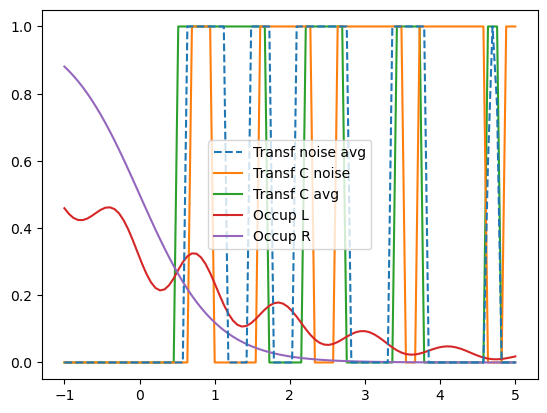

In [197]:
#transf_noise_avg = np.heaviside(occupf_L(Es)-occupf_R(Es),0)
nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)

print("Input current noise avg: ", input_current)
print("Output current noise avg: ", output_current)
print("Noise noise avg: ", nois)
print("Efficiency noise avg: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

nois = noise(transf_C_noise, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_C_noise, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_C_noise, Es,occupf_L, occupf_R, coeff_out)

print("Input current C noise: ", input_current)
print("Output current C noise: ", output_current)
print("Noise noise C: ", nois)
print("Efficiency noise C: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

nois = noise(transf_C_avg, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_C_avg, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_C_avg, Es,occupf_L, occupf_R, coeff_out)

print("Input current C avg: ", input_current)
print("Output current C avg: ", output_current)
print("Noise C avg: ", nois)
print("Efficiency C avg: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")

print("S*I limit: ", noise(transf_C_noise, Es,occupf_L, occupf_R, coeff_out)*tf.slice_current_integral(transf_C_avg, Es,occupf_L, occupf_R, coeff_in))

'''
nois = noise(transf_calc, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_calc, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_calc, Es,occupf_L, occupf_R, coeff_out)

print("Input current calc: ", input_current)
print("Output current calc: ", output_current)
print("Noise calc: ", nois)
print("Efficiency calc: ", output_current/input_current)
nois = noise(transf_gen, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_gen, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_gen, Es,occupf_L, occupf_R, coeff_out)

print("Input current gen: ", input_current)
print("Output current gen: ", output_current)
print("Noise gen: ", nois)
print("Efficiency gen: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")
nois = noise(transf_noise, Es,occupf_L, occupf_R, coeff_out)
input_current = tf.slice_current_integral(transf_noise, Es,occupf_L, occupf_R, coeff_in)
output_current = tf.slice_current_integral(transf_noise, Es,occupf_L, occupf_R, coeff_out)

print("Input current noise: ", input_current)
print("Output current noise: ", output_current)
print("Noise noise: ", nois)
print("Efficiency noise: ", output_current/input_current)
print("input * noise", input_current*nois)
print("\n")


'''

#plt.plot(Es,transf_gen, label = "Transf gen")
#plt.plot(Es, transf_noise, label = "Transf noise")
plt.plot(Es, transf_noise_avg,'--' ,label = "Transf noise avg", zorder = 3)
plt.plot(Es, transf_C_noise ,label = "Transf C noise", zorder = 2)
plt.plot(Es, transf_C_avg ,label = "Transf C avg", zorder = 1)
#plt.plot(Es, tf.transmission_avg_avg(0.3, Es, occupf_L, occupf_R, coeff_in, coeff_out), label = "transf test")
#plt.plot(Es, transf_calc, label = "Transf calc")

plt.plot(Es, occupf_L(Es), label = "Occup L")
plt.plot(Es, occupf_R(Es), label = "Occup R")
plt.legend()
#plt.ylim([0,1])
plt.show()

In [198]:
targets = np.linspace(0.05,0.25,10) #*tf.pmax(TL, TR)
outputs = []
turs = []
deltaT = 0.5
muL = -1
TR = 1-deltaT
TL = 1+deltaT
muR = 0
for target in targets:
        res = minimize(minimize_noise_avg, init_transf, args = (Es,occupf_L, occupf_R, coeff_in, coeff_out, "thermal"), bounds=(((0,1),)*len(Es)),
                constraints = [{'type':'eq', 'fun': tf.slice_pow_constraint, 'args':(Es,occupf_L, occupf_R, coeff_out, target)}])
                                #{'type':'ineq', 'fun': tf.slice_current_integral, 'args':(Es,occupf_L, occupf_R, coeff_in)}])
        transf_noise_avg = res.x
        nois = noise(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
        input_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_in)
        output_current = tf.slice_current_integral(transf_noise_avg, Es,occupf_L, occupf_R, coeff_out)
        tur = nois*input_current
        outputs.append(output_current)
        turs.append(tur)


67.27088579299013


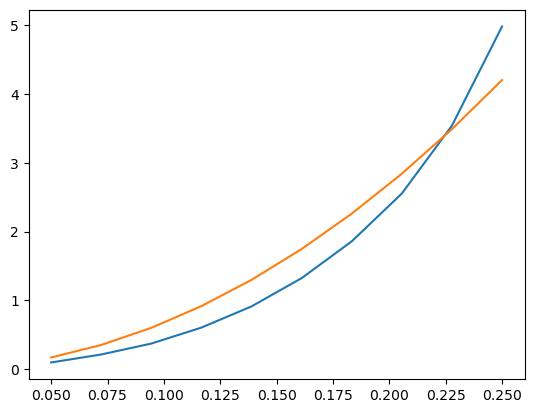

In [199]:
outputs = np.array(outputs)
turs = np.array(turs)
#res = Polynomial.fit(outputs, turs, deg=2)
res = np.polyfit(outputs, turs, 2)
comp = np.polyval(res, outputs)
res = least_squares(lambda theta: theta*outputs**2 - turs, 1)
comp = res.x[0]*outputs**2
#comp = 70*outputs**2

print(res.x[0])
plt.plot(outputs, turs)
plt.plot(outputs, comp)
plt.show()

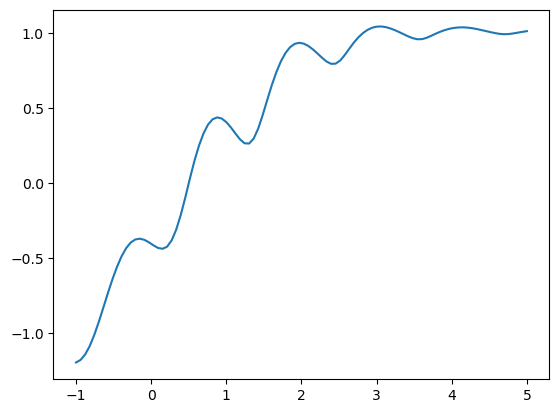

In [200]:
nom = occupf_L(Es) - occupf_R(Es)
denom = occupf_L(Es)*(1-occupf_L(Es)) + occupf_R(Es)*(1-occupf_R(Es))
plt.plot(Es, nom/denom)
plt.show()

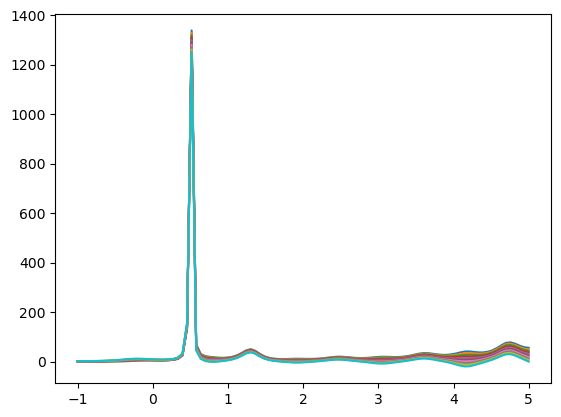

In [201]:
plusF = occupf_L(Es)*(1-occupf_R(Es)) + occupf_R(Es)*(1-occupf_L(Es))
occupdiff = occupf_L(Es) - occupf_R(Es)
unknown_transf = lambda lamda: plusF/(2*occupdiff**2) - lamda/(2*coeff_out(Es)*occupdiff)

for lamda in np.linspace(-1,1,10):
    plt.plot(Es, unknown_transf(lamda))
#plt.ylim([0,1])
plt.show()

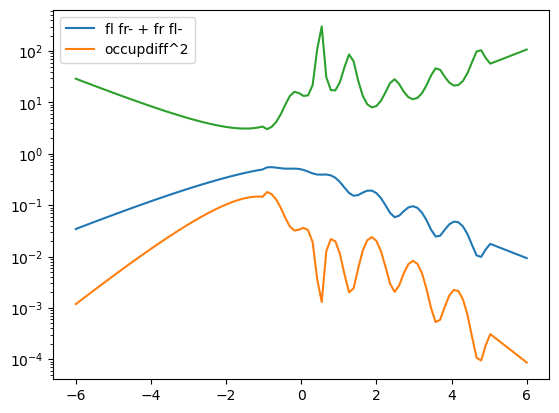

In [202]:
o_Es = np.linspace(-6,6,100)
plusF = occupf_L(o_Es)*(1-occupf_R(o_Es)) + occupf_R(o_Es)*(1-occupf_L(o_Es))
#plt.plot(Es, occupf_L(Es)*(1-occupf_R(Es)), label = "fl fr-")
#plt.plot(Es, occupf_R(Es)*(1-occupf_L(Es)), label = "fr fl-")
plt.plot(o_Es, plusF, label = "fl fr- + fr fl-")
plt.plot(o_Es, (occupf_L(o_Es) - occupf_R(o_Es))**2, label = "occupdiff^2")
plt.plot(o_Es, plusF/(occupf_L(o_Es) - occupf_R(o_Es))**2)
plt.yscale("log")
plt.legend()
plt.show()


In [ ]:
transf_calc = maybe_transf(Es, occupf_L, occupf_R, coeff_out, target)

0.7323011635675281


: 